# 0. 라이브러리 import

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# 1. 사진 읽어오기 및 얼굴 인식
- opencv는 채널이 RGB가 아닌 BGR로 표현
- dlib활용 face detector선언 후 얼굴 인식

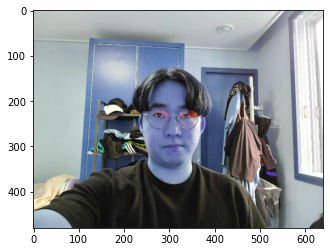

In [6]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
h,w,_ = img_bgr.shape
if h-w<0 :
    img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
else :
    img_bgr = cv2.resize(img_bgr, (480, 640))
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

In [7]:
# bgr => rgb 채널로 변경, 및 얼굴 detection
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(236, 184) (390, 339)]]


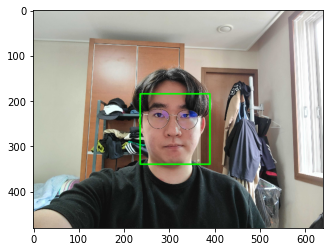

In [8]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 2. 인식한 얼굴에서 랜드마크 추출
- 눈, 코, 입, 턱의 좌표를 추출한다

In [9]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [10]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


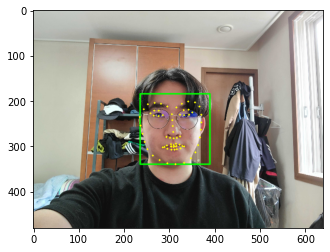

In [11]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 3. sticker 붙이기

## 3-1) Landmark를 활용해서 sticker_area 구하기
- 수염을 붙이기 위해서 33번 점을 활용 (코끝)
- w, h => 얼굴을 인식한 전체 사각형 (size = 155:155)

In [12]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[33][0]
    y = landmark[33][1]# - dlib_rect.width()//2
    # 얼굴을 인식한 사각형의 크기
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(309, 268)
(x,y) : (310,282)
(w,h) : (155,155)


## 3-2) 수염 이미지 가져오기
- 수염 이미지의 크기를 사각형의 크기와 동일하게 ```resize```를 해준다.
- 수염 이미지를 뿌려줄 **좌측 상단**의 값 (```refined_x```, ```refined_y```) 설정
    - ```y<0``` = 사진 영역 위로 나가는 경우
    - ```x<0``` = 시잔 영역 왼쪽으로 나가는 경우

In [13]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ccat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))    # 얼굴을 detection한 bos의 사이즈로 resize
print (img_sticker.shape)

(155, 155, 3)


In [14]:
refined_x = x - img_sticker.shape[1] // 2  # left
refined_y = y - img_sticker.shape[0] // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    print (img_sticker.shape)
    refined_y = 0
    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (233,205)


## 3-3) sticker_area 영역 확인
- x값 범위 : 좌측(refined_x)점 부터 스티커의 길이만큼 더한 범위
- y값 범위 : 

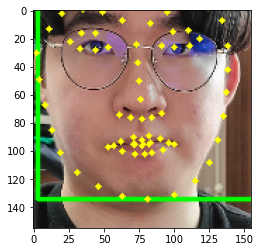

In [15]:
plt.imshow(img_show_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]])

In [16]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

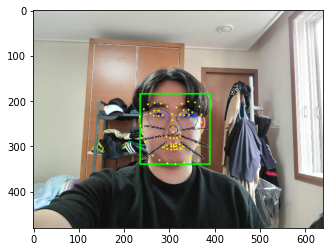

In [17]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

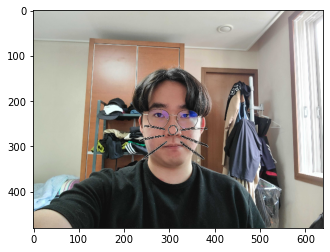

In [18]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 다양한 변수에 따른 영향도 분석


In [19]:
# 이미지들의 경로 저장
image_paths =[]
image_paths.append(os.getenv('HOME')+'/aiffel/camera_sticker/images/image3.jpg')
image_paths.append(os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg')
image_paths.append(os.getenv('HOME')+'/aiffel/camera_sticker/images/side.jpg')
image_paths.append(os.getenv('HOME')+'/aiffel/camera_sticker/images/uptodown.jpg')

## 4-1) 이미지 읽기 함수 : ```load_image```
- 입력인자
    - list형식으로 이미지들의 경로를 입력
- 출력
    - 사진들을 rgb채널의 ndarray로 열고 리스트에 담아서 반환

In [20]:
def load_image(paths):
    img_lst = []
    
    # 입력받은 경로가 list일 경우, for문을 돌면서 list에 이미지를 담는다.
    if str(type(paths)) == "<class 'list'>" :
        for path in paths:
            img_bgr = cv2.imread(path)
            h, w, _ = img_bgr.shape
            if h-w < 0 :
                img_bgr = cv2.resize(img_bgr, (640, 480))
            else :
                img_bgr = cv2.resize(img_bgr, (480, 640))

            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_lst.append(img_rgb)
    
    # 하나의 경로로 이미지를 읽어 들이고 list에 담는다.
    else : 
        img_bgr = cv2.imread(paths)
        h, w, _ = img_bgr.shape
        if h-w < 0 :
            img_bgr = cv2.resize(img_bgr, (640, 480))
        else :
            img_bgr = cv2.resize(img_bgr, (480, 640))

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_lst.append(img_rgb)
    
    return img_lst

In [21]:
# 이후에 사용될 사진들을 미리 img_lst에 담아 둔다.
img_lst = load_image(image_paths)

## 4-2) 얼굴인식 함수 : ```face_detection```
- 입력인자
    - ```img_rgb``` : ndarray형태의 image를 입력으로 받음
    - ```inner```
        - ```True``` : 입력받은 image로부터 얼굴은 인식한 결과물 (```dlib_rects```, ```list_landmarks```)를 반환
        - ```False(default)``` : 반환하는 값은 따로 없고, 사진에 대한 detection결과만 사진으로 출력
- 출력인자
    - 사진 결과물 출력 및 얼굴인식 Bounding Box, landmark좌표

In [22]:
def face_detection(img_rgb, inner=False):
    img_show = img_rgb.copy()

    # 얼굴 인식
    dlib_rects = detector_hog(img_rgb, 3)

    if dlib_rects :
        print("얼굴 인식 성공")
           
        for dlib_rect in dlib_rects:
            l = dlib_rect.left()
            t = dlib_rect.top()
            r = dlib_rect.right()
            b = dlib_rect.bottom()

            cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
            
        if not inner :
#             print(dlib_rects) # 찾은 얼굴영역 좌표
            plt.imshow(img_show)
            plt.show()
            print("marking landmark...")
        
        list_landmarks = []
        for dlib_rect in dlib_rects:
            points = landmark_predictor(img_rgb, dlib_rect)
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            list_landmarks.append(list_points)

        for landmark in list_landmarks:
            for idx, point in enumerate(list_points):
                cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
        
        if not inner :
            plt.imshow(img_show)
            plt.show()
            print("-"*30+'\n')
    else :
        print("얼굴 인식 실패")
        return False
    
    if inner:
        return dlib_rects, list_landmarks


## 4-3) 스티커 붙이기 함수 : ```stick```
- 기존에 ```path```를 인자로 받아서 load_image함수를 사용해 사진들의 list를 만들었지만, 다른 함수들과의 사용을 위해서 바로 image들의 리스트로 받는 것으로 변경
- 입력 인자
    - ```img_lst``` : path로부터 image를 읽은 ndarray형태의 image들이 담긴 list
        - 하나의 image가 ndarray의 형태로 전달되면 내부적으로 list에 담아서 함수 실행
- 출력
    - 고양이 스티커를 붙여서 사진을 출력해준다.
- 작동은 위에서 스티커를 붙이는 동작과 동일

In [124]:
def stick(img_lst, angle=0) :
#      path를 입력받을 때는
#     img_lst = []
#     img_lst = load_image(path)
    if str(type(img_lst)) != "<class 'list'>":
        img_lst = [img_lst]
    
    for img in img_lst :
        try :
            dlib_rects, list_landmarks = face_detection(img, inner=True)
        except :
            return "얼굴 인식 실패"
        
        for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
            x = landmark[33][0]
            y = landmark[33][1]# - dlib_rect.width()//2
            # 얼굴을 인식한 사각형의 크기
            w = dlib_rect.width()
            h = dlib_rect.width()
        
        # 스티커 가져오기
        sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ccat.png'
        img_sticker = cv2.imread(sticker_path)
        img_sticker = cv2.resize(img_sticker, (w,h))    # 얼굴을 detection한 bos의 사이즈로 resize
        if angle:
            img_sticker = rotate_image(img_sticker, angle=angle)
        
        refined_x = x - img_sticker.shape[1] // 2  # left
        refined_y = y - img_sticker.shape[0] // 2  # top
        
        if refined_y < 0 :
            img_sticker = img_sticker[-refined_y:]
            refined_y = 0
            
        sticker_area = img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
                    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
        
#         if angle :
#             img = rotate_image(img, angle=angle)
        
        plt.imshow(img)
        plt.show()
        
        print("짠")
        

얼굴 인식 성공


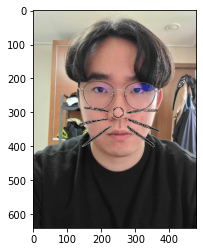

짠


In [24]:
stick(img_lst[0])

## 4-4) 얼굴 각도 조정 함수 : ```rotate_image```
- 입력인자
    - ```image``` : ndarray형식의 image
    - ```angle``` : 회전을 원하는 각도(ex. 10, 20, 30 ...) 
        - ```angle``` > 0 : 시계 방향
        - ```angle``` < 0 : 반시계 방향
    - ```save```
        - True : 노트북 파일과 동일 위치에 rotate.jpg이미지를 저장.
- 결과물
    - 회전을 한 ndarray형태의 이미지 및 저장되는 image

In [25]:
def rotate_image(image, angle, save=False) :
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, -angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    if save :
        print('저장경로 : ./rotate.jpg')
        cv2.imwrite('rotate.jpg', result)
    return result

저장경로 : ./rotate.jpg


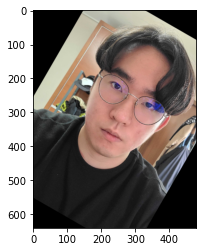

In [134]:
# 30도 rotation확인, save=True
img_lst = load_image(image_paths)
plt.imshow(rotate_image(img_lst[0], 30, save=True))

얼굴 인식 성공


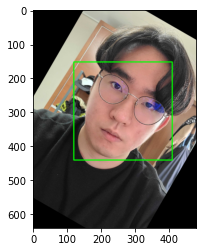

marking landmark...


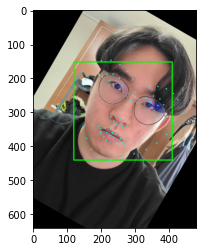

------------------------------



In [27]:
# rotation + face_detection
face_detection(rotate_image(img_lst[0], 30), inner=False)

In [135]:
face_detection(rotate_image(img_lst[0], 45), inner=False)

얼굴 인식 실패


False

얼굴 인식 성공


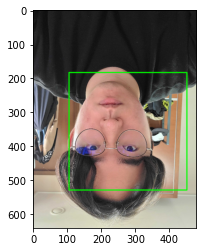

marking landmark...


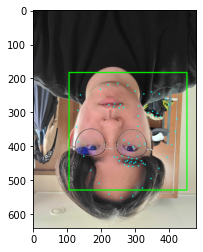

------------------------------



In [136]:
face_detection(rotate_image(img_lst[0], 180), inner=False)

얼굴 인식 성공


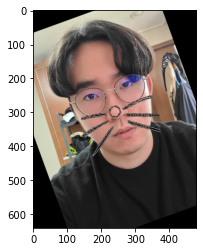

짠


In [125]:
# rotation + sticker
stick(rotate_image(img_lst[0], -20), angle=-20)

### 4-4) 추가
- 정면을 본 사진 이외에도 고개를 돌린 상태로 얼굴 인식을 시도해보았다.

얼굴 인식 성공


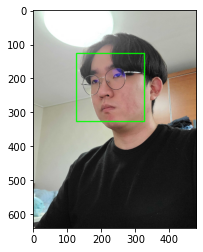

marking landmark...


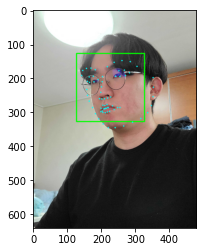

------------------------------

얼굴 인식 성공


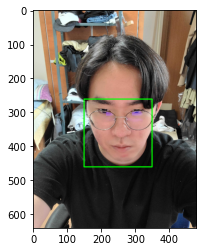

marking landmark...


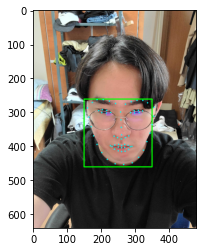

------------------------------



In [137]:
for img in img_lst[2:4] :
    face_detection(img)

## 4-5) 이미지 밝기 조절 함수 : ```mod_brightness```
- 입력인자
    - ```img``` : ndarray형식의 image
    - ```brightness```
        - ```True(Default)``` : 이미지를 밝게 조절
        - ```False``` : 이미지를 어둡게 조절
- 출력
    - 밝기를 수정한 ndarray형태의 image를 반환

In [29]:
def mod_brightness(img, brightness=True):
    
    if brightness :
        m = np.ones(img.shape, dtype="uint8") * 100
        result = cv2.add(img, m)
    else :
        m = np.ones(img.shape, dtype="uint8") * 50
        result = cv2.subtract(img, m)
        
    return result

얼굴 인식 성공


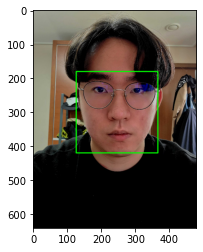

marking landmark...


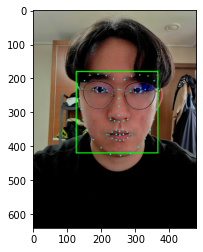

------------------------------



In [130]:
# 어둠게 + face_detection
for img in img_lst[:1]:
    dark_img = mod_brightness(img, brightness=False)
    face_detection(dark_img)

얼굴 인식 성공


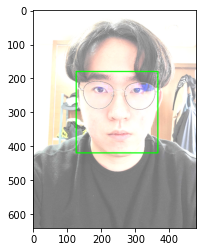

marking landmark...


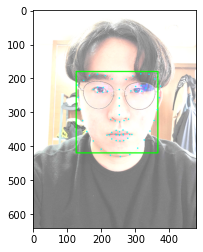

------------------------------



In [131]:
# 밝게 + face_detection
for img in img_lst[:1]:
    bright_img = mod_brightness(img, brightness=True)
    face_detection(bright_img)

얼굴 인식 성공


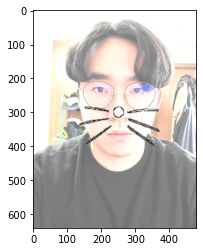

짠


In [132]:
# 밝게 + sticker
for img in img_lst[:1]:
    bright_img = mod_brightness(img, brightness=True)
    stick([bright_img])

## 4-6) 촬영거리 조절 함수 : ```paddedzoom```
- 이미지를 축소할 경우에 가장자리를 0으로 Padding 해준다.
- 입력인자
    - ```img``` : ndarray형식의 image
    - ```zoom```
        - ```0<zoom<1``` : 축소
        - ```zoom=1``` : 그대로 출력
        - ```zoom>1``` : 확대

In [112]:
def paddedzoom(img, zoom) :
    out = np.zeros(img.shape)
    zoomed = cv2.resize(img, dsize=(0,0), fx = zoom, fy = zoom)
    
    h, w, _ = img.shape
    zh, zw, _ = zoomed.shape
    
    if zoom<1 :
        out[(h-zh)//2:-(h-zh)//2, (w-zw)//2:-(w-zw)//2] = zoomed
    elif zoom > 1:
        out = zoomed[(zh-h)//2 : -(zh-h)//2, (zw-w)//2:-(zw-w)//2]
    else :
        out = img
        
    return out.astype(np.uint8)

얼굴 인식 성공


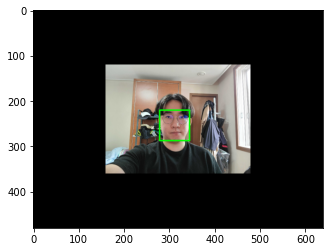

marking landmark...


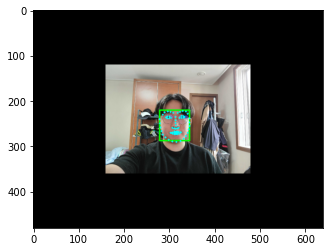

------------------------------



In [115]:
# zoom rate = 0.5
face_detection(paddedzoom(img_lst[1], 0.5))

얼굴 인식 성공


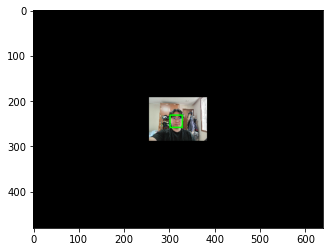

marking landmark...


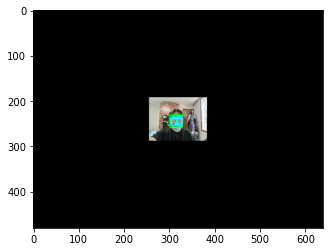

------------------------------



In [116]:
# zoom rate = 0.2
face_detection(paddedzoom(img_lst[1], 0.2))

얼굴 인식 성공


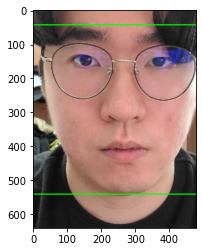

marking landmark...


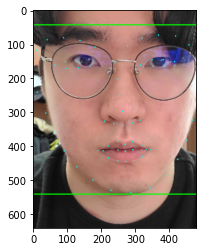

------------------------------



In [121]:
# zoom rate = 2
face_detection(paddedzoom(img_lst[0], 2))

In [122]:
# zoom rate = 3
face_detection(paddedzoom(img_lst[0], 3))

얼굴 인식 실패


False

# 정리

- 0~4번에 대한 내용 중 간단한 변수와 스티커의 위치를 계산해 보았다.
![image](https://user-images.githubusercontent.com/48716219/92125205-b971a200-ee39-11ea-9732-8e76ffb22558.png)


- 4번에서는 이미지를 다양하게 수정하개면서 얼굴을 제대로 인식하는지 확인을 해보았다.
    1. 얼굴의 각도
        - 정면을 본 상태로 회전을 시켜서 얼굴을 인식해보았다.
            - 30도에서는 얼굴을 인식했지만 Landmark는 조금 어긋나있고, 45도에서는 인식을 못하고 있다.
            - 180도를 회전 시켰을 때는 얼굴을 인식했다고 출력되면서 Box는 잘 찾은 것 같지만 실제로 Landmark를 찍어보면 눈, 코, 입, 턱을 제대로 찾지 못하고 있다.
            - 사람의 얼굴을 인식을 하는데 먼저 제일 중요한 부분이 얼굴의 가로와 세로의 비율을 기준으로 먼저 얼굴의 틀을 인식을 하고 Landmark를 이후에 세부적으로 찾는 것 같다. 하지만 Landmark는 어느정도 기울어 있는(30도) 사진같은 경우 어느정도 찾고 있지만 반면에 180도 회전한 사진의 결과를 보면 Landmark는 눈은 얼굴의 윗부분, 코는 중간 부분, 입은 아래를 보고 턱같은 경우는 제일 밑에를 통해서 찾으려고 하는 것 같다.  
        - 추가적으로 정면사진이 아닌 고개를 살짝 돌리고 대각선 방향에서 찍은 사진을 인식시켜보았다.
            - 결과는 대각선 방향 아래에서 찍은 경우, 위에서 아래로 찍은 경우 모두 얼굴과 Landmark를 제대로 찾았다.  
              
    2. 이미지의 밝기
        - HOG(Histogram of Oriented Gradient) feature를 사용하기 때문에 밝기의 경우 대부분 문제 없이 잘 인식해 주었다.
        - 비록 너무 어둡게, 너무 밝게 하면 픽셀값들이 0과 255에 전부 가까워 진다면 찾기 힘들겠지만 어느정도의 밝기 범위 안에서는 밝기가 변하는 방향(Gradient)만 고려해 주는 HOG feature의 특성상 밝기에 부관하게 동일한 표현(Representation)을 얻을 수 있다.
        
    3. 촬영거리
        - 촬영 거리는 이미지를 확대하고 축소를 해줌으로 써 조절을 해주었다.
        - 이미지를 0.2배로 줄이기도 했지만 육안으로는 사람이 얼굴 형태가 있는 것 같다만 인식하지 눈코입은 정확하게 인지하지 못한다. 하지만 생각보다 축소했을 때 얼굴을 찾아서 Landmark를 찍어주는 것을 확인 할 수 있었다.
        - 이미지를 확대할 경우 아무래도 전체 이미지의 틀 안에 Landmark들이 들어오지 않을 경우는 제대로 인식을 하지 못하는 것을 확인할 수 있었다.